# Script for Griggs rheology
## 2024 Oct Tian, Xiaochuan
## This python script reproduce Zhang 06 and also esitmate rheological parameters
### This python script is based on 


# LaMEM-vts-vtr-analyzer
#### This python script combine 
* LaMEM-topo-TV-analysis_new-general_cpu_conf.ipynb 
* LaMEM-TV-stress-analysis-P-T_axes.ipynb
* Include Focal mechanism plot
into one script.

Python 3.8
pip-3.8 show vtk  Name: vtk  Version: 9.1.0

author: xiaochuan Tian --2022 February @ Boston College

**input variables require manual input are annotated with< * >**

future potential updates are annotated with < todo >

**bugs are annoted with < BUG >**

##### Log:
* 20220208: make pltshow_block_or_not=False as default
* 20220209: 
    * fixed a BUG about finding the peak indices in Z_time and Zmean_time; 
    * Added two functions for plotting P&T axes and focal mechanism with diff depths; 
    * Added program timer
    * correct color scale for viscosity plot and combine crosssections into one
* 20220212:
    * update figure output format as .png (changed from .pdf) so that 
        * .png is smaller for focal mechanism (1Mb vs 3Mb)
        * .png opens faster in mac Preview
        * .png can be imported directly into Google doc whereas .pdf cannot
    * del all the temporal arrays to save memory load and can be a little faster
    * plt.close(figure) to take care of the warning of rcParam `figure.max_open_warning` but still slow
    * deleted alpha of beach plotting to take care of the warning
* 20220215:
    * 90% solved an unstable bug about finding the peaks from topography using try-except
* 20220217:
    * updated the 2 km grid size plots for higher resolution models 1 km grid size
* 20220222:
    * fixed a small bug so that only modifying i_plot can change all plotting time step
    * added the strain rate plot 
* 20220324:
    * output topo Zmean as out_data-Zmean.npy
    * add topo profile lines across Ridge
* 20220504:
    * added class obj_LaMEM_variable for auto input data from .vtr file
    * output data_valley_geometry.txt for input into excel file "sigma_xy-TV_relief.xlsx" for analysis
    * correct the sign of pressure to be negative for caculating the full stress tensor for P&T axes
* 20220830 for variable grid mesh setup in LaMEM-TV_depth-TF_strength.py(.ipynb):
    * read 3 coordinate vectors from binary .vtr files for generating mesh matrices (e.g. ZYmesh)
    * adding function _plot_XY_gridlines for plotting variable grid lines
#### todo:
* make manual input as an input file
* update the code block for importing arrays from .vtr to be able to import only the available ones rather than currently being rigidly specified [Done Tian220504]
* update the topography find_peaks with variable grid spacing

In [1]:
# pip show matplotlib


In [2]:
# pip show numpy
# pip install numpy

In [3]:
# -------------------------------------
# import all required python libraries
# -------------------------------------
import os
import math as m
import numpy as np
import matplotlib.pyplot as plt

import glob # for getting names of folders and files
#https://www.codegrepper.com/code-examples/python/how+to+read+and+write+a+sequential+data+files+in+python+at+the+same+time


from matplotlib.pyplot import cm
#https://matplotlib.org/stable/tutorials/colors/colormaps.html
topo_cMap = cm.seismic

#for interpolation from low resolution grid to smoother pcolor plot
# -------------------------------------
from scipy import interpolate
#for finding indices for the traverse ridge peaks and valley
from scipy.signal import find_peaks

#For 3D surface plot OR contour plot
import matplotlib
from mpl_toolkits import mplot3d

In [4]:
A = 1e-2 
#A = 1e-2 * 1e6

n = 3.5
Q = 310000 # J/mol
R = 8.314 # J/(mol K)?
epsilon  = np.logspace(-15,-4,30, base=10)
T = 600+273.15
eta = A**(-1/n) * np.exp(Q/(n*R*T))* epsilon**((1-n)/n)

(array([1.e-18, 1.e-16, 1.e-14, 1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04,
        1.e-02, 1.e+00]),
 [Text(1e-18, 0, '$\\mathdefault{10^{-18}}$'),
  Text(1e-16, 0, '$\\mathdefault{10^{-16}}$'),
  Text(1e-14, 0, '$\\mathdefault{10^{-14}}$'),
  Text(1e-12, 0, '$\\mathdefault{10^{-12}}$'),
  Text(1e-10, 0, '$\\mathdefault{10^{-10}}$'),
  Text(1e-08, 0, '$\\mathdefault{10^{-8}}$'),
  Text(1e-06, 0, '$\\mathdefault{10^{-6}}$'),
  Text(0.0001, 0, '$\\mathdefault{10^{-4}}$'),
  Text(0.01, 0, '$\\mathdefault{10^{-2}}$'),
  Text(1.0, 0, '$\\mathdefault{10^{0}}$')])

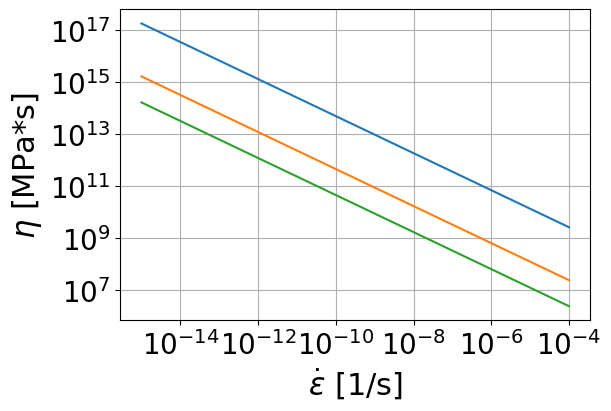

In [5]:
# 
figure = plt.figure(constrained_layout=True)
figure.set_size_inches(6,4)
ax = figure.add_gridspec(1,1)

f1 = figure.add_subplot(ax[:,:])
f1.yaxis.label.set_size(22)
f1.xaxis.label.set_size(22)
f1.set_xlabel('$\dot\epsilon$ [1/s]',fontsize=22)
f1.set_ylabel('$\eta$ [MPa*s]',fontsize=22, color='k')

#f1.set_title("test", fontsize=22)

for i in range(3):
#     A = 1e-2
#     n = 3.5
#     Q = 310000 # J/mol
#     R = 8.314 # J/(mol K)
#     epsilon  = np.logspace(-15,-4,30, base=10)
    T = np.array([500,900,1300])
    T = T+273.15
    eta = A**(-1/n) * np.exp(Q/(n*R*T[i])) * epsilon**((1-n)/n)

    f1.loglog(epsilon, eta)
f1.grid()
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
#ax.set_xscale('log')


(array([ 200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 [Text(200.0, 0, '200'),
  Text(400.0, 0, '400'),
  Text(600.0, 0, '600'),
  Text(800.0, 0, '800'),
  Text(1000.0, 0, '1000'),
  Text(1200.0, 0, '1200'),
  Text(1400.0, 0, '1400'),
  Text(1600.0, 0, '1600')])

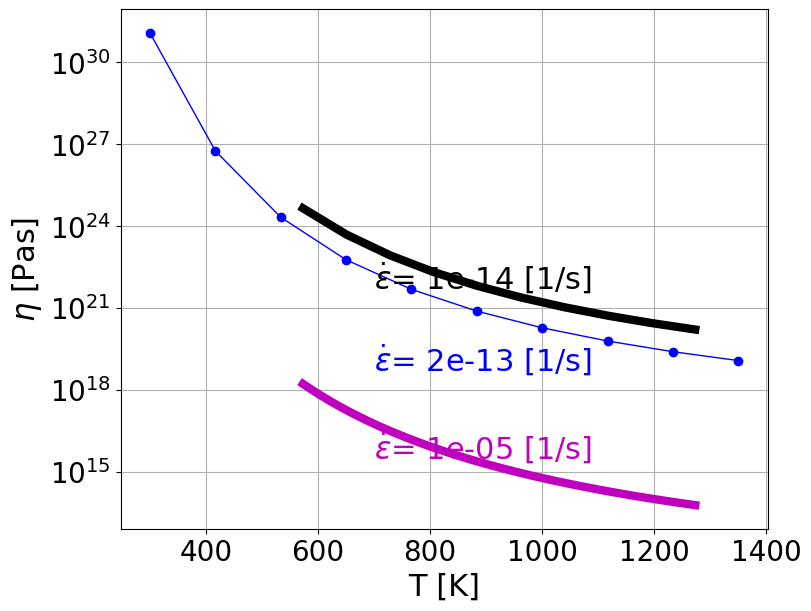

In [6]:
# overpressure
figure = plt.figure(constrained_layout=True)
figure.set_size_inches(8,6)
ax = figure.add_gridspec(1,1)

f1 = figure.add_subplot(ax[:,:])
f1.yaxis.label.set_size(22)
f1.xaxis.label.set_size(22)
f1.set_xlabel('T [$\degree$C]',fontsize=22)
f1.set_xlabel('T [K]',fontsize=22)

# f1.set_ylabel('eta [MPas]',fontsize=22, color='k')
f1.set_ylabel('$\eta$ [Pas]',fontsize=22, color='k')

#f1.set_title("test", fontsize=22)

A = 1e-2
n = 3.5
Q = 310000 # J/mol
R = 8.314 # J/(mol K)
epsilon  = 1e-14
T = np.linspace(300,1000,10)
T = T+273.15
eta = A**(-1/n) * np.exp(Q/(n*R*T)) * epsilon**((1-n)/n)     * 1e6
#f1.semilogy(T-273.15,eta,linewidth=6,color='k')
f1.semilogy(T,eta,linewidth=6,color='k')

text_to_disp=f'$\dot\epsilon$= {epsilon} [1/s]'
plt.text(700,5e21,text_to_disp,fontsize=22)

A = 1e-2
n = 3.5
Q = 310000 # J/mol
R = 8.314 # J/(mol K)
epsilon  = 1e-5
T = np.linspace(300,1000,100)
T = T+273.15
eta = A**(-1/n) * np.exp(Q/(n*R*T)) * epsilon**((1-n)/n)     * 1e6
#f1.semilogy(T-273.15,eta,linewidth=6,color='m')
f1.semilogy(T,eta,linewidth=6,color='m')

text_to_disp=f'$\dot\epsilon$= {epsilon} [1/s]'
plt.text(700,3e15,text_to_disp,fontsize=22,color='m')

#A = 0.5e-46  #1e-2 #
A = 1e-2 #

n = 3.5
Q = 310000 # J/mol
R = 8.314 # J/(mol K)
epsilon  = 2e-13
T = np.linspace(300,1350,10)
#T = T+273.15
#T = T

# eta = (A*1e6)**(-1/n) * np.exp(Q/(n*R*T)) * epsilon**((1-n)/n)   *(1/4)   #  * 1e6
eta = A**(-1/n) * np.exp(Q/(n*R*T)) * epsilon**((1-n)/n)   *(1/4)  *  4   * 1e6

f1.semilogy(T,eta,linewidth=1,color='b',marker='o')
text_to_disp=f'$\dot\epsilon$= {epsilon} [1/s]'
plt.text(700,5e18,text_to_disp,fontsize=22,color='b')


f1.grid()
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

#ax.set_xscale('log')




# derivation of unit of A
From the standard flow rule:
## $\dot\epsilon = A \sigma^n exp(\frac{-Q}{RT})$
Because what is inside exp() is unitless
* Q ~ [J/(mol)]
* R ~  [J/(molK)]
* T ~ [K]

## --> A should have the same unit of $\dot\epsilon/\sigma^n$
which is 
## * $s^{-1} \times (Pa^{-n} or MPa^{-n})$


# All in one plot

1681.8960526315789
1.2597999292303363e+18
1681.8960526315789
6.525101834345799e+18


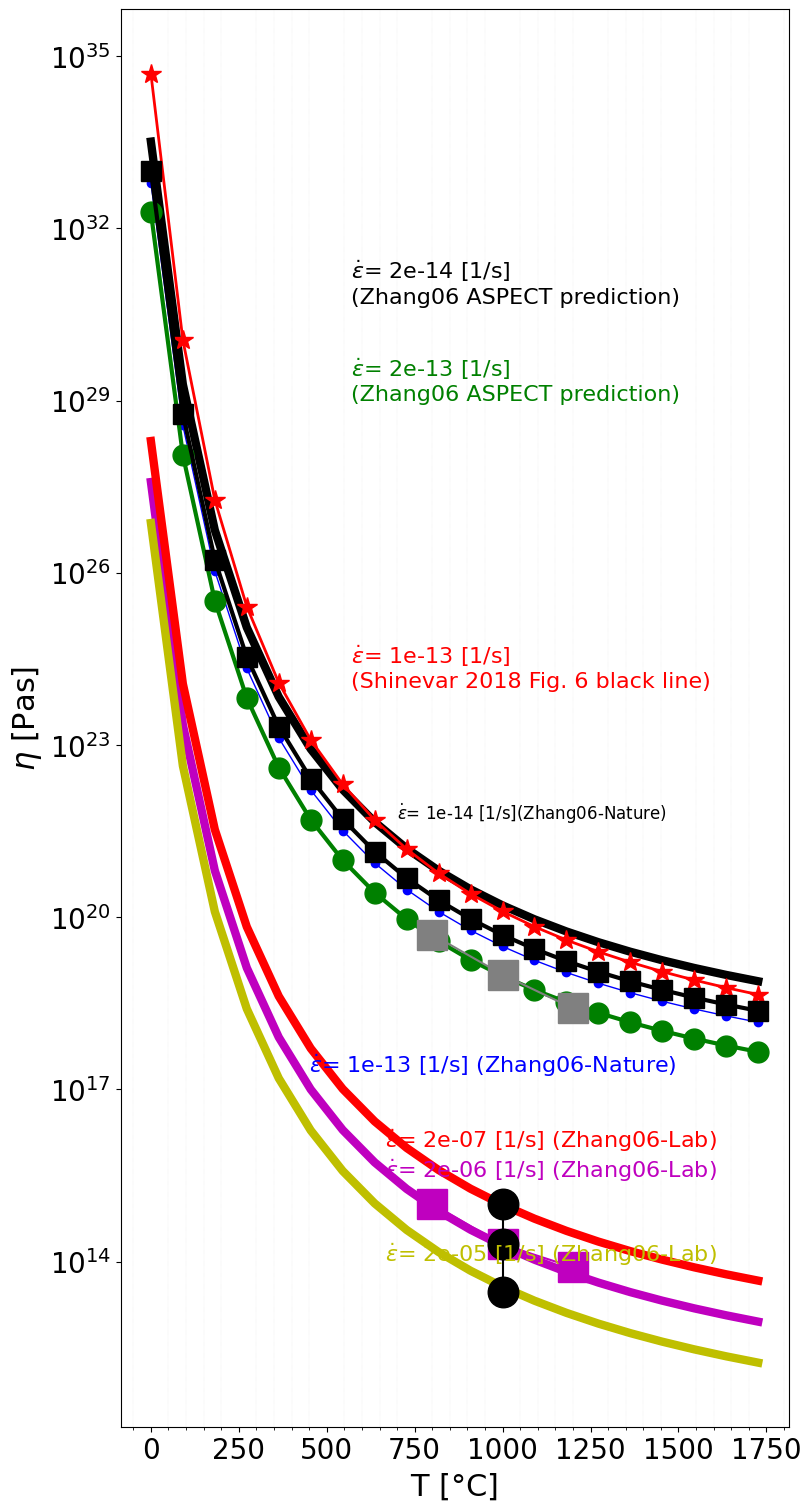

In [18]:
import matplotlib.ticker as ticker


# Zhang 06 parameters + Reproducing Shinevar et al., 2018 Fig. 6
figure = plt.figure(constrained_layout=True)
figure.set_size_inches(8,15)
ax = figure.add_gridspec(1,1)

f1 = figure.add_subplot(ax[:,:])
f1.yaxis.label.set_size(22)
f1.xaxis.label.set_size(22)
f1.set_xlabel('T [$\degree$C]',fontsize=22)
#f1.set_xlabel('T [K]',fontsize=22)
# f1.set_ylabel('eta [MPas]',fontsize=22, color='k')
f1.set_ylabel('$\eta$ [Pas]',fontsize=22, color='k')

#f1.set_title("test", fontsize=22)

T = np.linspace(273.15,2000,20)  # [K]

# ------------------------
# for Zhang 06 parameter
# ------------------------
#  Zhang06 LAB strain rate 1e-5
# ------------------------
epsilon  = 1e-5
epsilon = 2e-6
A = 1e-2
n = 3.5
Q = 310000 # J/mol
R = 8.314 # J/(mol K)
eta = A**(-1/n) * np.exp(Q/(n*R*T)) * epsilon**((1-n)/n)     * 1e6
f1.semilogy(T-273.15,eta,linewidth=6,color='m')
#f1.semilogy(T,eta,linewidth=6,color='m')
text_to_disp=f'$\dot\epsilon$= {epsilon} [1/s] (Zhang06-Lab)'
plt.text(666,3e15,text_to_disp,fontsize=16,color='m')

# ------------------------
# for Zhang 06 parameter
# ------------------------
#  Zhang06 LAB strain rate 1e-5
# ------------------------
epsilon  = 1e-5
epsilon = 2e-5
A = 1e-2
n = 3.5
Q = 310000 # J/mol
R = 8.314 # J/(mol K)
eta = A**(-1/n) * np.exp(Q/(n*R*T)) * epsilon**((1-n)/n)     * 1e6
f1.semilogy(T-273.15,eta,linewidth=6,color='y')
#f1.semilogy(T,eta,linewidth=6,color='m')
text_to_disp=f'$\dot\epsilon$= {epsilon} [1/s] (Zhang06-Lab)'
plt.text(666,1e14,text_to_disp,fontsize=16,color='y')

# ------------------------
# for Zhang 06 parameter
# ------------------------
#  Zhang06 LAB strain rate 1e-5
# ------------------------
epsilon = 2e-7
A = 1e-2
n = 3.5
Q = 310000 # J/mol
R = 8.314 # J/(mol K)
eta = A**(-1/n) * np.exp(Q/(n*R*T)) * epsilon**((1-n)/n)     * 1e6
f1.semilogy(T-273.15,eta,linewidth=6,color='r')
#f1.semilogy(T,eta,linewidth=6,color='m')
text_to_disp=f'$\dot\epsilon$= {epsilon} [1/s] (Zhang06-Lab)'
plt.text(666,1e16,text_to_disp,fontsize=16,color='r')

# ------------------------
# Zhang06 Natural strain rate 1e-13
# ------------------------
epsilon  = 1e-13
eta = A**(-1/n) * np.exp(Q/(n*R*T)) * epsilon**((1-n)/n)   * 1e6

f1.semilogy(T-273.15,eta,linewidth=1,color='b',marker='o')
text_to_disp=f'$\dot\epsilon$= {epsilon} [1/s] (Zhang06-Nature)'
plt.text(450,2e17,text_to_disp,fontsize=16,color='b')

# # ------------------------
# # strain rate 1e-13 show <error> when forgetting to transform K to T when plotting
# # ------------------------
# epsilon  = 1e-13
# eta = A**(-1/n) * np.exp(Q/(n*R*T)) * epsilon**((1-n)/n)   * 1e6
# #f1.semilogy(T-273.15,eta,linewidth=1,color='b',marker='o')
# #f1.semilogy(T,eta,linewidth=1,color='y',marker='o')

# ------------------------
# Zhang06 strain rate 1e-14
# ------------------------
epsilon  = 1e-14
eta = A**(-1/n) * np.exp(Q/(n*R*T)) * epsilon**((1-n)/n)     * 1e6
f1.semilogy(T-273.15,eta,linewidth=6,color='k')
text_to_disp=f'$\dot\epsilon$= {epsilon} [1/s](Zhang06-Nature)'
plt.text(700,5e21,text_to_disp,fontsize=12)


# ------------------------

# Shinevar 2018 Fig. 6
# ------------------------
epsilon  = 1e-13  #2e-13
A = 10**(-23.9) #[Pa^-n * s^-1] vs 1e-2 [MPa^-n * s^-1]  
#(for n=3.5)
# A of 1e-2   [MPa^-n * s^-1]    =   1e-2 * 1e6^(-n) [Pa^-n * s^-1] =   1e-23 [Pa^-n * s^-1] 
n = 3.5
Q = 340*1e3 #J/mol #310000 # J/mol
R = 8.314 # J/(mol K)
eta = A**(-1/n) * np.exp(Q/(n*R*T)) * epsilon**((1-n)/n)  

f1.semilogy(T-273.15,eta,linewidth=2,color='r',marker='*',markersize=15)
text_to_disp=f'$\dot\epsilon$= {epsilon} [1/s] \n(Shinevar 2018 Fig. 6 black line)'
plt.text(570,1e24,text_to_disp,fontsize=16,color='r')



# ------------------------
# ASPECT A of 0.5e-46 strain rate 2e-13 
# ------------------------
A = 1e-23 #0.5e-46 #1e-2 #
n = 3.5
Q = 310000 # J/mol
R = 8.314 # J/(mol K)
epsilon  = 2.e-13 #2e-13
# eta = (A*1e6)**(-1/n) * np.exp(Q/(n*R*T)) * epsilon**((1-n)/n)   *(1/4)   #  * 1e6
eta = A**(-1/n) * np.exp(Q/(n*R*T)) * epsilon**((1-n)/n)    /2 # * 1e6
#f1.semilogy(T-273.15,eta,linewidth=1,color='b',marker='o')
f1.semilogy(T-273.15,eta,linewidth=3,color='g',marker='o',markersize=15)

text_to_disp=f'$\dot\epsilon$= {epsilon} [1/s] \n(Zhang06 ASPECT prediction)'
plt.text(570,1e29,text_to_disp,fontsize=16,color='g')
print(0.5*(T[-4]+T[-5]))
print(0.5*(eta[-4]+eta[-5]))
f1.grid()
f1.grid(which='minor', linestyle=':', linewidth='0.25', color='lightgrey')
f1.minorticks_on()

# ------------------------
# ASPECT A of 0.5e-46 strain rate 2e-14 
# ------------------------
A = 1e-23 #0.5e-46 #1e-2 #
n = 3.5
Q = 310000 # J/mol
R = 8.314 # J/(mol K)
epsilon  = 2.e-14 #2e-13
# eta = (A*1e6)**(-1/n) * np.exp(Q/(n*R*T)) * epsilon**((1-n)/n)   *(1/4)   #  * 1e6
eta = A**(-1/n) * np.exp(Q/(n*R*T)) * epsilon**((1-n)/n)    /2 # * 1e6
#f1.semilogy(T-273.15,eta,linewidth=1,color='b',marker='o')
f1.semilogy(T-273.15,eta,linewidth=3,color='k',marker='s',markersize=15)

text_to_disp=f'$\dot\epsilon$= {epsilon} [1/s] \n(Zhang06 ASPECT prediction)'
plt.text(570,5e30,text_to_disp,fontsize=16,color='k')
print(0.5*(T[-4]+T[-5]))
print(0.5*(eta[-4]+eta[-5]))
f1.grid()
f1.grid(which='minor', linestyle=':', linewidth='0.25', color='lightgrey')
f1.minorticks_on()


# # Enable major gridlines
# plt.grid(True, which='major', linestyle='-')

# # Enable minor gridlines on the y-axis
# plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(3))  # 2 minor ticks per major tick
# plt.grid(True, which='minor', linestyle='--', alpha=0.5)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

#ax.set_xscale('log')


# plotting data for constant V but changing T
Temp = np.array([1073,1273,1473])
eta = np.array([5.e19, 1e19, 2.59e18])
epsilon= np.array([1.1e-13, 1.77e-13, 2.45e-13])
sigma=np.array([1.5e7, 3.65e6, 1.28e6])
f1.semilogy(Temp-273.15, eta, marker='s',markersize=22, color='grey')




eta_lab=np.array([1e15, 2e14, 8e13])
f1.semilogy(Temp-273.15, eta_lab, marker='s',markersize=22, color='m')


# plotting data for constant T but changing V
Temp = np.array([1273,1273,1273])
eta = np.array([3e13, 2e14, 1e15])
# epsilon= np.array([6.28e-15, 1.77e-13, 1.42e-12])
# sigma=np.array([1.4e6, 3.65e6, 6.6e6])
f1.semilogy(Temp-273.15, eta, marker='o',markersize=22, color='k')


## epsilon


Slope of the semilogy plot: 282120.73775467067


/Users/tian_bc/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3378: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


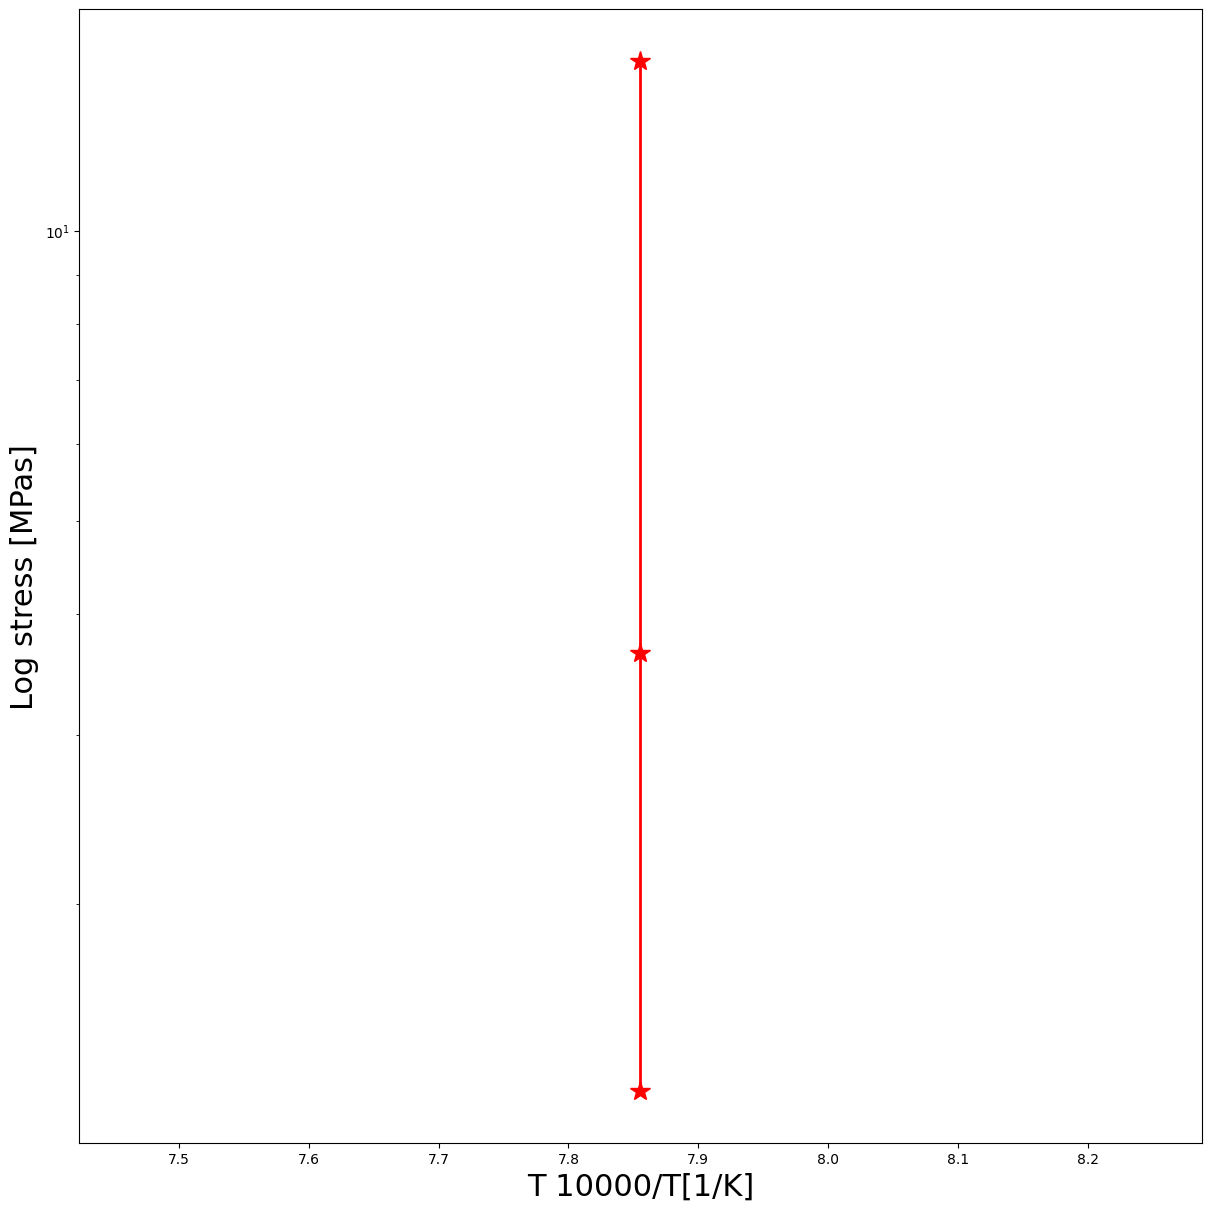

In [19]:
figure = plt.figure(constrained_layout=True)
figure.set_size_inches(12,12)
ax = figure.add_gridspec(1,1)

f1 = figure.add_subplot(ax[:,:])
f1.yaxis.label.set_size(22)
f1.xaxis.label.set_size(22)
f1.set_xlabel('T 10000/T[1/K]',fontsize=22)
f1.set_ylabel('Log stress [MPas]',fontsize=22, color='k')
#f1.semilogy(10000/Temp,sigma/1e6, base=np.e,linewidth=2,color='r',marker='*',markersize=15)
f1.semilogy(10000/Temp,sigma/1e6,linewidth=2,color='r',marker='*',markersize=15)

# Calculate the slope on the log-transformed y-values
y = sigma
x = 1/Temp
#log_y = np.log10(y)  # Take log base 10 of y values
# should be natural log for things in the exponent to come out!!!
log_y = np.log(y)  # Take log base 10 of y values

slope, intercept = np.polyfit(x, log_y, 1)  # Perform linear fit

#slopeQ = slope/(np.log10(epsilon/A)*(1/n/R))
#slopeQ = slope*R*n/(np.log10(epsilon/A))  
slopeQ = slope*R*n



print(f"Slope of the semilogy plot: {slopeQ}")

In [18]:
slopeQ

-0.17904542848535954

# Reproducing Fig. 7 of Zhang et al., 2006


(0.1, 100)

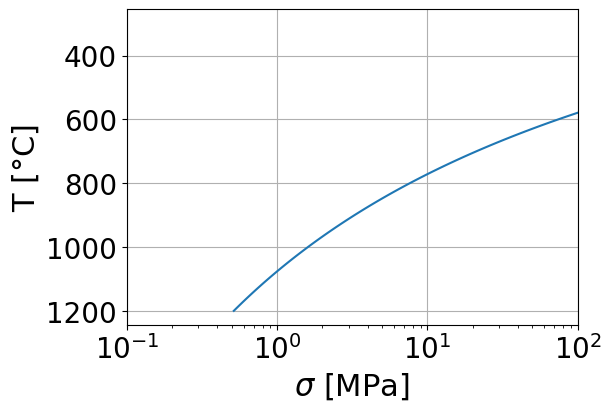

In [11]:
# Reproducing Fig. 7 of Zhang et al., 2006
figure = plt.figure(constrained_layout=True)
figure.set_size_inches(6,4)
ax = figure.add_gridspec(1,1)

f1 = figure.add_subplot(ax[:,:])
f1.yaxis.label.set_size(22)
f1.xaxis.label.set_size(22)
f1.set_xlabel('$\sigma$ [MPa]',fontsize=22)
f1.set_ylabel('T [$\degree$C]',fontsize=22, color='k')
#f1.set_title("test", fontsize=22)


A = 1e-2  # [MPa*s]
#A = 1e10
n = 3.5
Q = 310000 # J/mol
R = 8.314 # J/(mol K) 
epsilon  = 1e-14    #[1/s]
T = np.linspace(300,1200,100)
T = T+273.15 # in [K]
sigma = A**(-1/n) * np.exp(Q/(n*R*T)) * epsilon**(1/n)

f1.semilogx(sigma,T-273.15)
f1.grid()
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.gca().invert_yaxis()
plt.xlim([0.1,100])
#ax.set_xscale('log')


(array([1.e-18, 1.e-16, 1.e-14, 1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04,
        1.e-02, 1.e+00]),
 [Text(1e-18, 0, '$\\mathdefault{10^{-18}}$'),
  Text(1e-16, 0, '$\\mathdefault{10^{-16}}$'),
  Text(1e-14, 0, '$\\mathdefault{10^{-14}}$'),
  Text(1e-12, 0, '$\\mathdefault{10^{-12}}$'),
  Text(1e-10, 0, '$\\mathdefault{10^{-10}}$'),
  Text(1e-08, 0, '$\\mathdefault{10^{-8}}$'),
  Text(1e-06, 0, '$\\mathdefault{10^{-6}}$'),
  Text(0.0001, 0, '$\\mathdefault{10^{-4}}$'),
  Text(0.01, 0, '$\\mathdefault{10^{-2}}$'),
  Text(1.0, 0, '$\\mathdefault{10^{0}}$')])

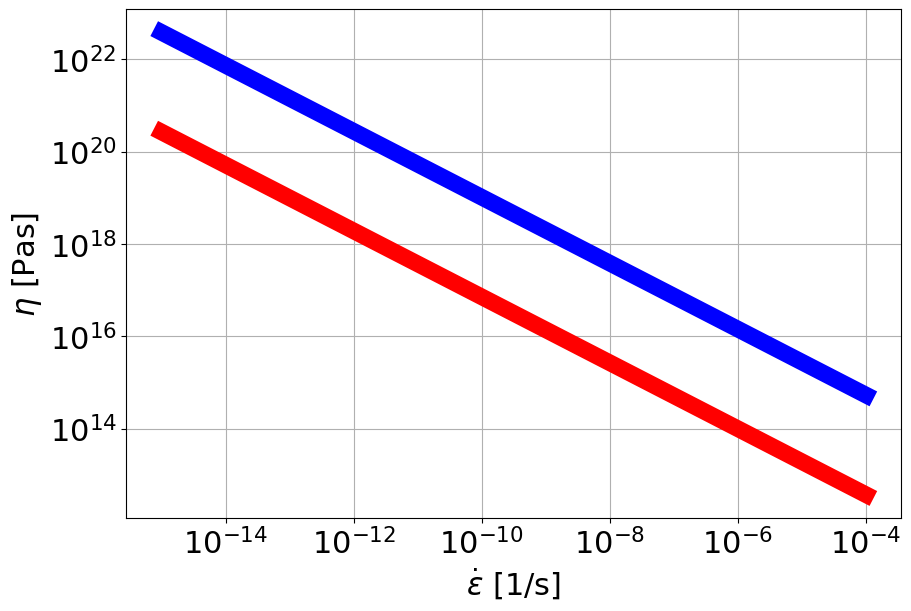

In [12]:
# overpressure
figure = plt.figure(constrained_layout=True)
figure.set_size_inches(9,6)
ax = figure.add_gridspec(1,1)

f1 = figure.add_subplot(ax[:,:])
f1.yaxis.label.set_size(22)
f1.xaxis.label.set_size(22)
f1.set_xlabel('$\dot\epsilon$ [1/s]',fontsize=22)
f1.set_ylabel('$\eta$ [Pas]',fontsize=22, color='k')
#f1.set_title("test", fontsize=22)

for i in range(2):
    A = 1e-2
    n = 3.5
    Q = 310000 # J/mol
    R = 8.314 # J/(mol K)
    epsilon  = np.logspace(-15,-4,30, base=10)
    T = np.array([600,1200])+273.15
    #T = 1400
    eta = A**(-1/n) * np.exp(Q/(n*R*T[i]))*epsilon**((1-n)/n)  * 1e6
    colors=['b','r']  
    f1.loglog(epsilon, eta,linewidth=12,color=colors[i])
f1.grid()
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)
#ax.set_xscale('log')


# Explore ASEPCT rheology parameters

In [13]:
# ASPECT manual for diffusion dislocation:
# https://aspect-documentation.readthedocs.io/en/latest/parameters/Material_20model.html

In [14]:
pip install orix


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [15]:
import orix

In [16]:
from orix.crystal_map import Phase, 

SyntaxError: trailing comma not allowed without surrounding parentheses (1099806151.py, line 1)

In [ ]:
from orix.crystal_map import Phase
from orix.quaternion import symmetry, Orientation
from orix.plot import plot_pole_figure

# Example data
orientation = Orientation.from_euler(45, 45, 45, symmetry.Cubic())
plot_pole_figure(orientation, poles="111")


# https://orix.readthedocs.io/en/latest/tutorials/pole_density_function.html

In [ ]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from orix import plot
from orix.crystal_map import Phase
from orix.data import ti_orientations
from orix.sampling import sample_S2
from orix.vector import Miller, Vector3d

# We'll want our plots to look a bit larger than the default size
plt.rcParams.update(
    {
        "figure.figsize": (10, 5),
        "lines.markersize": 2,
        "font.size": 15,
        "axes.grid": False,
    }
)
w, h = plt.rcParams["figure.figsize"]

In [ ]:
O = ti_orientations(allow_download=True)


In [ ]:
g = Miller(hkil=(0, 1, -1, 1), phase=Phase(point_group=O.symmetry))
g = g.symmetrise(unique=True)

In [ ]:
poles = O.inv().outer(g, lazy=True, progressbar=True, chunk_size=2000)
poles.shape

In [ ]:
poles.scatter(
    hemisphere="both",
    alpha=0.02,
    figure_kwargs={"figsize": (2 * h, h)},
    axes_labels=["X", "Y"],
)

In [ ]:
fig = plt.figure(figsize=(2 * h, h))
ax0 = fig.add_subplot(121, projection="stereographic", hemisphere="upper")
ax1 = fig.add_subplot(122, projection="3d")

v_mesh = sample_S2(resolution=10, method="equal_area")

ax0.scatter(v_mesh)
ax0.set_labels("X", "Y", None)
ax0.show_hemisphere_label()

ax1.scatter(*v_mesh.data.T)

lim = 1
ax1.set(
    xlim=(-lim, lim),
    ylim=(-lim, lim),
    zlim=(-lim, lim),
    xticks=(-lim, 0, lim),
    yticks=(-lim, 0, lim),
    zticks=(-lim, 0, lim),
    xlabel="X",
    ylabel="Y",
    zlabel="Z",
    box_aspect=(1, 1, 1),
);

In [ ]:
num = (10_000, 100_000, 1_000_000, 10_000_000)

fig, ax = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(2 * h, 2 * h),
    subplot_kw={"projection": "stereographic"},
)
ax = ax.ravel()

for i, n in enumerate(num):
    v = Vector3d.random(n)
    ax[i].pole_density_function(v, log=False, vmin=0.8, vmax=1.2)
    ax[i].set_labels("X", "Y", None)
    ax[i].set(title=str(n))